<a href="https://colab.research.google.com/github/PandaTofu/BookRecommendationSystem/blob/main/clickbaits_chinese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

导入所需要的第三方库就

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from transformers import BertModel, BertTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import re
import jieba
from jieba import analyse
from gensim import corpora, similarities
from gensim import models as gensim_models
import matplotlib.pyplot as plt
from matplotlib.image import imread
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager

# 数据获取

下载WCD（Webchat Clickbaits Datasets）数据集，作为本次标题党检测的训练和测试数据

In [ ]:
# 读取数据集
df = pd.read_csv('data/wechat_clickbait/all_labeled.csv',
                 usecols=['NAME', 'TITLE', 'CONTENT', 'T_LABEL'])

数据预处理

In [ ]:
# 如果存在空文本，则删除
df = df.replace('', None)
df = df.dropna(how='any')

# 将原数据集的三分类(0, 1, 2)改为二分类(0, 1)
df = df.replace(2, 1)

# 特征提取

自定义文本数据集，并添加bert分词器，使得数据加载过程中会自动分词，输出结果作为文本分类模型的输入

In [ ]:
class TextEmbeddingDataset(Dataset):
    def __init__(self, titles, contents, labels):
        self.all_title = titles
        self.all_content = contents
        self.all_label = labels
        self.max_len = 40

        # 加载预训练的Bert分词器
        self.tokenizer = BertTokenizer.from_pretrained('./bert-base-chinese')

    def __getitem__(self, index):
        titles = self.all_title[index]
        contents = self.all_content[index]
        labels = self.all_label[index]

        # 文本分词
        encoded_pair = self.tokenizer(
            titles,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt')

        data = [titles, contents, encoded_pair]
        return data, labels

    def __len__(self):
        # 获取数据集的样本数量
        return len(self.all_title)

提取标题、内容和标签，并拆分成训练集和测试集

In [ ]:
titles = df['TITLE'].values.tolist()
contents = df['CONTENT'].values.tolist()
labels = df['T_LABEL'].values.tolist()
split_data = train_test_split(
    titles, contents, labels, test_size=0.2,random_state=0)
title_train, title_test, content_train, content_test, labels_train, labels_test = split_data

batch_size = 16
data_train = TextEmbeddingDataset(title_train, content_train, labels_train)
dl_train = DataLoader(
    dataset=data_train,
    batch_size=batch_size,
    shuffle=True)
data_test = TextEmbeddingDataset(title_test, content_test, labels_test)
dl_test = DataLoader(
    dataset=data_test,
    batch_size=batch_size,
    shuffle=True)

# 深度学习模型

定义TextCNN网络，选择预训练的bert模型作为词嵌入层

In [ ]:
# 设置随机种子
SEED = 1234
torch.manual_seed(1234)

# 定义textCNN模型
class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        emb_dim = 768   ##每个词向量长度, 即Bert的隐层数量
        n_class = 2 ##类别数
        in_ch = 1   ##输入的channel数
        n_k = 2     ## 每种卷积核的数量
        k_size = [2,3,4]  ## 卷积核list

        self.bert = BertModel.from_pretrained('./bert-base-chinese') ## 文本嵌入层
        # 冻结bert模型的参数，不需要更新
        for param in self.bert.parameters():
            param.requires_grad = False

        self.convs = nn.ModuleList([nn.Conv2d(in_ch, n_k, (k, emb_dim)) for k in k_size])  ## 卷积层
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(k_size) * n_k, n_class)  ##全连接层

    def embedding(self, encoded_pair):
        input_ids = encoded_pair['input_ids'].squeeze()
        attn_masks = encoded_pair['attention_mask'].squeeze()
        token_type_ids = encoded_pair['token_type_ids'].squeeze()

        # 用bert编码
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attn_masks,
            token_type_ids=token_type_ids,
            output_hidden_states=True)

        # 将每一层的第一个token(cls向量)提取出来，拼在一起当作textCnn的输入
        hidden_states = outputs.hidden_states
        cls_embeddings = hidden_states[1][:, 0, :].unsqueeze(1)  # [batch_size, 1, hidden]
        for i in range(2, len(hidden_states)):
            cls_embeddings = torch.cat((cls_embeddings, hidden_states[i][:, 0, :].unsqueeze(1)), dim=1)

        return cls_embeddings

    def forward(self, x):
        x = x[2]
        emb_x = self.embedding(x)
        # [batch len, text size, emb dim]
        x = emb_x.unsqueeze(1)
        #  [batch len, in_ch, text size, emb dim]
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        # len(k_size)*[batch size, n_k, text len]
        x = [F.max_pool1d(line, line.size(2)).squeeze(2) for line in x]
        # len(k_size)*[batch size, n_k]
        x = torch.cat(x, 1)
        # [batch size, n_k*len(k_size)]
        x = self.dropout(x)
        # [batch size, n_k*len(k_size)]
        logit = self.fc(x)
        # [batch size, n_class]
        return logit

设置计算操作所在的设备（CPU或GPU）

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

定义训练步骤，用于更新模型参数

In [ ]:
def train_step(model, dataloader, optimizer, loss_fn, i_epoch, max_epoch):
    total_loss = 0.0
    correct_samples = 0.0
    total_samples = 0.0

    model.train()
    tbar = tqdm(dataloader, desc='Train')
    for data, labels in tbar:
        titels, contents, enc_pair = data
        enc_pair, labels = enc_pair.to(device), labels.to(device)
        batch_data = [titels, contents, enc_pair]

        # 前向传播
        logit = model(batch_data)
        loss = loss_fn(logit, labels)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()

        # 梯度下降
        optimizer.step()

        total_loss += loss.item()
        correct_samples += (torch.argmax(logit, dim=1) == labels).sum().item()

        total_samples += labels.size(0)
        training_loss = total_loss / total_samples
        training_acc = correct_samples / total_samples

        # 更新tbar信息
        tbar.set_description(f'Train Epoch [{i_epoch+1}/{max_epoch}]')
        tbar.set_postfix({'loss': f'{training_loss:.4f}', 'acc': f'{training_acc*100:.2f}%'})

    return training_loss, training_acc

定义验证步骤，用户评估模型性能

In [ ]:
def validate_step(model, dataloader, loss_fn):
    total_loss = 0.0
    correct_samples = 0.0
    total_samples = 0.0

    with torch.no_grad():
        tbar = tqdm(dataloader, desc='Validation')
        for data, labels in tbar:
            titels, contents, enc_pair = data
            enc_pair, labels = enc_pair.to(device), labels.to(device)
            batch_data = [titels, contents, enc_pair]

            logit = model(batch_data)
            loss = loss_fn(logit, labels)
            pred = torch.argmax(logit, dim=1)

            total_loss += loss.item()
            correct_samples += (pred == labels).sum().item()

            total_samples += labels.size(0)
            valing_loss = total_loss / total_samples
            valing_acc = correct_samples / total_samples

            tbar.set_postfix({'loss': f'{valing_loss:.4f}', 'acc': f'{valing_acc*100:.2f}%'})

    return valing_loss, valing_acc

定义完整的训练流程，执行“训练+验证”的循环周期，并保存模型参数和评估结果

In [ ]:
def train_model(model, max_epoch = 5):
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    train_results = pd.DataFrame(columns=['train_loss', 'train_acc', 'val_loss', 'val_acc'],
                                 index=range(max_epoch))
    for i_epoch in range(max_epoch):
        train_loss, train_acc = train_step(model, dl_train, opt, loss_fn, i_epoch, max_epoch)
        val_loss, val_acc = validate_step(model, dl_test, loss_fn)
        train_results.loc[i_epoch] = [train_loss, train_acc, val_loss, val_acc]
    model_name = model.__class__.__name__
    torch.save(model.state_dict(), model_name+'.pth')
    train_results.to_csv(model_name+'_pm.csv')

获取TextCNN模型（由于训练过程非常耗时，选择提前训练，然后加载训练好的模型参数）

In [ ]:
textCNN = TextCNN().to(device)
#train_model(textCNN) # 训练模型
textCNN.load_state_dict(torch.load('TextCNN.pth')) # 加载训练好的模型

<All keys matched successfully>

引入注意力机制，定义TextRNN+Attention模型，依然选择bert模型作为词嵌入层

In [ ]:
class TextRNN_Attention(nn.Module):
    def __init__(self):
        super(TextRNN_Attention, self).__init__()
        emb_dim = 768   ##每个词向量长度, 即Bert的隐层数量
        dropout = 0.2
        hidden_size = 256 #隐藏层数量
        n_class = 2 ##类别数
        n_layers = 2 ##双层LSTM

        self.bert = BertModel.from_pretrained('./bert-base-chinese') ## 文本嵌入层
        # 冻结bert模型的参数，不需要更新
        for param in self.bert.parameters():
            param.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, hidden_size, n_layers,
                            bidirectional=True, batch_first=True, dropout=dropout)
        self.tanh1 = nn.Tanh()
        self.w = nn.Parameter(torch.zeros(hidden_size * 2))
        self.tanh2 = nn.Tanh()
        self.fc = nn.Linear(hidden_size * 2, n_class)

    def embedding(self, encoded_pair):
        input_ids = encoded_pair['input_ids'].squeeze()
        attn_masks = encoded_pair['attention_mask'].squeeze()
        token_type_ids = encoded_pair['token_type_ids'].squeeze()

        # 用bert编码
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attn_masks,
            token_type_ids=token_type_ids,
            output_hidden_states=True)

        # 将每一层的第一个token(cls向量)提取出来，拼在一起当作textCnn的输入
        hidden_states = outputs.hidden_states
        cls_embeddings = hidden_states[1][:, 0, :].unsqueeze(1)  # [batch_size, 1, hidden]
        for i in range(2, len(hidden_states)):
            cls_embeddings = torch.cat((cls_embeddings, hidden_states[i][:, 0, :].unsqueeze(1)), dim=1)

        return cls_embeddings

    def forward(self, x):
        x = x[2]
        # [batch len, text size]
        x = self.embedding(x)
        # [batch size, text size, embedding]
        output, (hidden, cell) = self.lstm(x)
        # output = [batch size, text size, num_directions * hidden_size]
        M = self.tanh1(output)
        # [batch size, text size, num_directions * hidden_size]
        alpha = F.softmax(torch.matmul(M, self.w), dim=1).unsqueeze(-1)
        # [batch size, text size, 1]
        out = output * alpha
        # [batch size, text size, num_directions * hidden_size]
        out = torch.sum(out, 1)
        # [batch size, num_directions * hidden_size]
        out = F.relu(out)
        # [batch size, num_directions * hidden_size]
        out = self.fc(out)
        # [batch size, num_classes]
        return out

获取TextRNN+Attention模型（同样地，省去了耗时的训练过程，直接加载训练好的模型参数）

In [ ]:
textRNN = TextRNN_Attention().to(device)
#train_model(textRNN) # 训练模型
textRNN.load_state_dict(torch.load('TextRNN_Attention.pth')) # 加载训练好的模型

<All keys matched successfully>

当标题带有诱导性的关键词或句式时，用TextCNN/RNN进行分类检测是非常高效的。但针对非诱导性标题却文不对题的情况，则需要计算文本相似度。

因此，提出基于TF-IDF计算文本相似度的模型，通过计算标题与文章内容的相似度来判断一个标题是否为标题党。

In [ ]:
# 设置停用词
analyse.set_stop_words('StopWords.txt')

# 定义基于TFIDF的文本相似度计算模型
class TFIDFSim():
    def __init__(self):
        self.stop_words = [":", " ", "#", "*", "=", "的", "，", "”", "？", "?", "《", "》", "|", "\xa0"]
        self.threshold = 0.04

    def __call__(self, data):
        titles, contents = data[0], data[1]
        logit = self.predict(titles, contents)
        return logit

    def split_sentence(self, doc): #断句
        pattern = r'[\n。?？!！|]+'
        sents = re.split(pattern, doc.strip())
        return sents

    def split_words(self, sents): #分词
        words = []
        for sent in sents:
            word_list = [w for w in jieba.lcut(sent.strip()) if w not in self.stop_words]
            words.append(word_list)
        return words

    def calculate_similarity(self, title, content):
        t_sent = title.strip()
        c_sents = self.split_sentence(content)
        sents = [t_sent] + c_sents
        words = self.split_words(sents)

        w_dictionary = corpora.Dictionary(words)
        corpus = [w_dictionary.doc2bow(word) for word in words]
        w_tfidf = gensim_models.TfidfModel(corpus)
        corpus_tfidf = w_tfidf[corpus]
        n_features = len(w_dictionary.token2id)
        similar_matrix = similarities.MatrixSimilarity(corpus_tfidf, num_features = n_features)
        sim_mat = similar_matrix[corpus]
        sim_val = np.max(sim_mat[0, 1:])
        return sim_val

    def predict(self, batch_titles, batch_contents):
        batch_size = len(batch_titles)
        logit = torch.Tensor(np.zeros((batch_size, 2)) + 0.5)
        for i in range(batch_size):
            title = batch_titles[i]
            content = batch_contents[i]
            sim_val = self.calculate_similarity(title, content)
            if sim_val > self.threshold: # 判定为相似
                var = (sim_val - self.threshold) / (1.0 - self.threshold) * 0.5
                logit[i, 0] += var
                logit[i, 1] -= var
            elif sim_val < self.threshold: # 判定为不相似
                var = (self.threshold - sim_val) / self.threshold * 0.5
                logit[i, 0] -= var
                logit[i, 1] += var
        return logit

创建计算文本相似度的模型

In [ ]:
tfidf_sim = TFIDFSim()

# 算法融合与模型评估

前面提出了TextCNN和TextRNN两种文本分类神经网络，以及基于TF-IDF计算文本相似度的模型。现在，基于投票机制将三种不同算法进行融合，以提高整体模型的准确性和鲁棒性。

In [ ]:
class VotingModel():
    def __init__(self, model_list, weight):
        self.n_model = len(model_list)
        self.model_list = model_list
        self.weight = np.array(weight)
        self.weight = self.weight / self.weight.sum()

    def __call__(self, data):
        logit = self.predict(data)
        return logit

    def predict(self, batch_data):
        batch_size = len(batch_data[0])
        logit = torch.Tensor(np.zeros((batch_size, 2)))
        for i in range(self.n_model):
            model = self.model_list[i]
            w = self.weight[i]
            logit_i = model(batch_data)
            logit += w*logit_i
        return logit

设置各模型的投票权重，创建融合后的投票模型。

In [ ]:
weight = [4.5, 5, 0.5]
voting_model= VotingModel([textCNN, textRNN, tfidf_sim], weight)

输入验证集，计算损失函数(loss)和准确率(acc)，评估投票模型的性能。

In [ ]:
loss_fn = nn.CrossEntropyLoss()
validate_step(voting_model, dl_test, loss_fn)

Validation: 100%|██████████| 202/202 [15:50<00:00,  4.70s/it, loss=0.0086, acc=94.88%]


(0.008623014555799316, 0.948773672772431)

# 结果分析和可视化

词频是文本分析中非常重要的特征之一，词云图则可以很好地展示文本的高频关键词。以正常标题为例，绘制词云图：

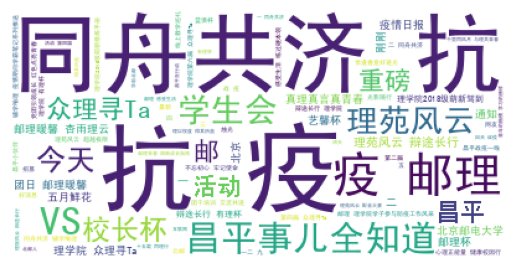

In [ ]:
wc = WordCloud(
    font_path='my_font.ttf',
    background_color="#ffffff",
    max_words=100,
    random_state=42
)

titles_norm = "".join(df[df['T_LABEL']==0]['TITLE'].values.tolist())
export_figname_norm = "normal_titiel_wordcloud"
wc.generate("".join(jieba.lcut(titles_norm)))
plt.figure(export_figname_norm)
plt.axis("off")
plt.imshow(wc)
plt.show()

通过绘制折线图，显示TextCNN/RNN模型在训练过程中的性能变化

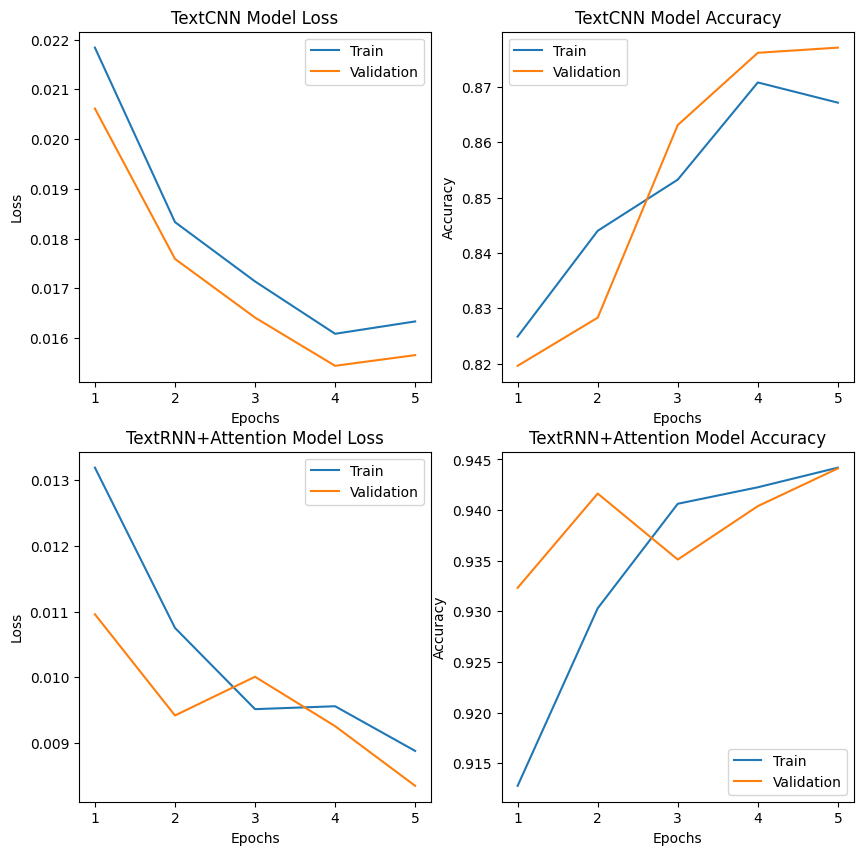

In [ ]:
# TextCNN的loss曲线
df = pd.read_csv('TextCNN_pm.csv', index_col=0)
cnn_train_loss = df['train_loss']
cnn_val_loss = df['val_loss']
max_epoch = len(cnn_train_loss)
epochs = range(1, max_epoch+1)
plt.figure(figsize=[10,10])
plt.subplot(2, 2, 1)
plt.title('TextCNN Model Loss')
plt.plot(epochs, cnn_train_loss, label='Train')
plt.plot(epochs, cnn_val_loss, label='Validation')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# TextCNN的acc曲线
cnn_train_acc = df['train_acc']
cnn_val_acc = df['val_acc']
max_epoch = len(cnn_train_acc)
epochs = range(1, max_epoch+1)
plt.subplot(2, 2, 2)
plt.title('TextCNN Model Accuracy')
plt.plot(epochs, cnn_train_acc, label='Train')
plt.plot(epochs, cnn_val_acc, label='Validation')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# TextRNN的loss曲线
df = pd.read_csv('TextRNN_Attention_pm.csv', index_col=0)
rnn_train_loss = df['train_loss']
rnn_val_loss = df['val_loss']
max_epoch = len(rnn_train_loss)
epochs = range(1, max_epoch+1)
plt.subplot(2, 2, 3)
plt.title('TextRNN+Attention Model Loss')
plt.plot(epochs, rnn_train_loss, label='Train')
plt.plot(epochs, rnn_val_loss, label='Validation')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# TextRNN的acc曲线
rnn_train_acc = df['train_acc']
rnn_val_acc = df['val_acc']
max_epoch = len(rnn_train_acc)
epochs = range(1, max_epoch+1)
plt.subplot(2, 2, 4)
plt.title('TextRNN+Attention Model Accuracy')
plt.plot(epochs, rnn_train_acc, label='Train')
plt.plot(epochs, rnn_val_acc, label='Validation')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 绘制
plt.show()

还可以做对比实验，对不同公众号的新闻分别进行分类，评估投票模型对标题党的敏感性，对比结果以柱状图呈现

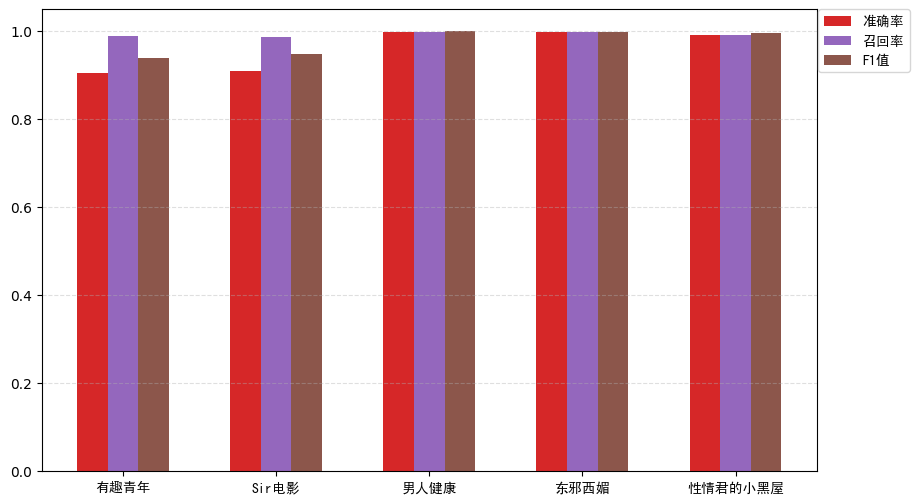

In [ ]:
# 绘制柱状图，比较分组结果的准确率、召回率、F1
df_grp_test = pd.read_csv('group_test_results.csv', index_col=0)
group_name = df_grp_test.columns.to_list()
y1 = df_grp_test.loc['accuracy']
y2 = df_grp_test.loc['recall']
y3 = df_grp_test.loc['f1_score']
x = np.arange(1, len(group_name)+1)
cn_font = font_manager.FontProperties(fname='my_font.ttf')
plt.figure(figsize=(10, 6), dpi=100)
plt.bar(x-0.2, y1, width=0.2, color='C3', label='准确率')
plt.bar(x,     y2, width=0.2, color='C4', label='召回率')
plt.bar(x+0.2, y3, width=0.2, color='C5', label='F1值')
plt.legend(bbox_to_anchor=(1.12, 1), loc=1, borderaxespad=0, prop=cn_font)
plt.grid(axis='y',alpha=0.4,ls='--')
plt.xticks(x,group_name, fontproperties=cn_font)
plt.show()

可以看到，一般标题党新闻较多的公众号（前两个：有趣青年和Sir电影）的分类效果低于后三个恶意标题党较多的公众号。